<a href="https://colab.research.google.com/github/EiriniNBI/LA_CRDS_Water_Isotope/blob/main/LA_CRDS_Water_Isotope_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
# pip install allantools

In [7]:
# !apt-get update

In [8]:
# # Install LaTeX (if not already done)
# !apt-get install texlive-fonts-recommended texlive-fonts-extra cm-super
# !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [9]:
import os
import time
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from matplotlib.dates import DateFormatter, MinuteLocator
import allantools
import requests
from zipfile import ZipFile
from io import BytesIO


In [10]:
# Ensure LaTeX text rendering and set the font to match your LaTeX document
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],  # Replace with your LaTeX document font
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 6,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'font.size': 8
})

#Allan variance calculation for given time series.

A time series with a total of $N$ data points can be segmented into $m$ groups, each containing $k = N/m$ data points. If each data point is acquired over a period of $t_i$, then the integration period for each group is $\tau_m = kt_i$. Under these conditions, the Allan variance is defined as follows:

$$
\sigma^2_{\text{Allan}}(\tau_m) = \frac{1}{2m} \sum_{j=1}^m (\delta_{j+1} - \delta_j)^2,
$$

where $\delta_{j+1}$ and $\delta_j$ represent the mean values of adjacent intervals $j$ and $j + 1$.

In [ ]:
import pandas as pd


def download_and_process_file(url, filename):
    # Download the zip file
    response = requests.get(url)
    if response.status_code == 200:
        # Open the zip file from the response content
        with ZipFile(BytesIO(response.content)) as the_zip:
            # Check if the desired file is in the zip
            if filename in the_zip.namelist():
                # Extract and process the specific .dat file
                with the_zip.open(filename) as file:
                    # Use pandas to read the .dat file, assuming it's whitespace delimited
                    data = pd.read_csv(file, delim_whitespace=True, header=0)
                    print(data.head())  # Print the first few rows

                    # Convert columns to appropriate data types
                    data['EPOCH_TIME'] = pd.to_numeric(data['EPOCH_TIME'])
                    data['Delta_18_16'] = pd.to_numeric(data['Delta_18_16'], errors='coerce')
                    data['Delta_D_H'] = pd.to_numeric(data['Delta_D_H'], errors='coerce')
                    data['H2O'] = pd.to_numeric(data['H2O'], errors='coerce')

                    return data
            else:
                print(f"{filename} not found in the zip file.")
    else:
        print(f"Failed to download the file from {url}. Status code: {response.status_code}")

# Usage
url = "https://zenodo.org/records/13152033/files/20231204_LACRDS_data_v1.zip?download=1"

filename = "04/HIDS2383-20231204-143030Z-DataLog_User.dat"
processed_data = download_and_process_file(url, filename)
if processed_data is not None:
    print(processed_data.head())

         DATE          TIME  FRAC_DAYS_SINCE_JAN1  FRAC_HRS_SINCE_JAN1  \
0  2023-12-04  14:30:24.933            337.646122          8103.506926   
1  2023-12-04  14:30:25.786            337.646132          8103.507163   
2  2023-12-04  14:30:26.640            337.646142          8103.507400   
3  2023-12-04  14:30:27.493            337.646152          8103.507637   
4  2023-12-04  14:30:28.346            337.646161          8103.507874   

   JULIAN_DAYS    EPOCH_TIME  ALARM_STATUS  INST_STATUS  CavityPressure  \
0   338.646122  1.701700e+09             0          963       50.001178   
1   338.646132  1.701700e+09             0          963       50.000008   
2   338.646142  1.701700e+09             0          963       49.998456   
3   338.646152  1.701700e+09             0          963       49.996175   
4   338.646161  1.701700e+09             0          963       49.997905   

   CavityTemp  ...   OutletValve  ValveMask          H2O  Delta_18_16  \
0   80.001327  ...  26305.23697

<ipython-input-9-ec59633e3fde>:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.2)


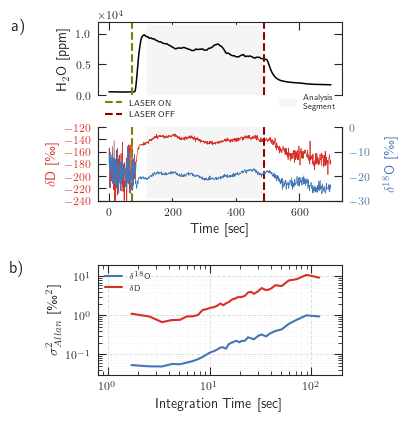

In [ ]:
data=processed_data.copy()

# Convert DATE and TIME to datetime
data['datetime'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])

sns.set_style("ticks")

# Define specific time ranges
start_time = '2023-12-04 15:00:00' #data start
end_time = '2023-12-04 15:11:40' #data end
hline_start_time = '2023-12-04 15:01:12' #LASER ON
hline_end_time = '2023-12-04 15:08:08' #LASER OFF
segment_start_time = '2023-12-04 15:02:00' #Analysis segment start
segment_end_time = '2023-12-04 15:08:00' #Analysis segment end

# Convert times
segment_start_seconds = (pd.to_datetime(segment_start_time) - pd.to_datetime(start_time)).total_seconds()
segment_end_seconds = (pd.to_datetime(segment_end_time) - pd.to_datetime(start_time)).total_seconds()
hline_start_seconds = (pd.to_datetime(hline_start_time) - pd.to_datetime(start_time)).total_seconds()
hline_end_seconds = (pd.to_datetime(hline_end_time) - pd.to_datetime(start_time)).total_seconds()

# Filter data
filtered_data = data[(data['datetime'] >= start_time) & (data['datetime'] <= end_time)].copy()

# Convert 'datetime' to seconds from the start
filtered_data['seconds'] = (filtered_data['datetime'] - filtered_data['datetime'].iloc[0]).dt.total_seconds()

# Plotting function for time series
def plot_time_series(ax1, ax2, ax3):
    ax1.plot(filtered_data['seconds'], filtered_data['H2O'], color='black', linewidth=1.1)
    ax1.set_ylim(0, 12000)
    ax1.axvline(hline_start_seconds, color='olive', linestyle='--')
    ax1.axvline(hline_end_seconds, color='darkred', linestyle='--')
    ax1.fill_betweenx([200, 11500], segment_start_seconds, segment_end_seconds, color='whitesmoke', label='Analysis\nSegment')
    ax1.set_ylabel(u'H$_{2}$O [ppm]')
    # ax1.legend(loc='upper right', fontsize='small', frameon=False, bbox_to_anchor=(1, 1), prop={'size': 6})

    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(direction='in', which='both', length=6, top=True, right=True, bottom=False, pad=5)
    ax1.set_xticklabels([])
      # Set y-axis to scientific notation
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax2.plot(filtered_data['seconds'], filtered_data['Delta_D_H'], color='#d73027', linewidth=0.5)
    ax2.axvline(hline_start_seconds, color='olive', linestyle='--', label='LASER ON')
    ax2.axvline(hline_end_seconds, color='darkred', linestyle='--', label='LASER OFF')
    ax2.fill_betweenx([-235, -110], segment_start_seconds, segment_end_seconds, color='whitesmoke', label='Analysis\nSegment')
    ax2.set_xlabel('Time [sec]')
    ax2.set_ylabel(u'$\delta$D [‰]', color='#d73027')
    ax2.tick_params(axis='y', labelcolor='#d73027')

    # Set y-limits explicitly after plotting

    ax2.spines['top'].set_visible(False)
    ax2.tick_params(direction='in', which='both', length=6, top=False, right=False, bottom=True, left=True, pad=5)
    ax2.set_ylim(-240, -120)  # Ensure ylim is set after all plotting commands

    ax2.set_yticks(np.linspace(-240, -120, num=7))  # This creates 7 evenly spaced ticks from -240 to -120
    # ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), frameon=False, fontsize='small', fancybox=True, shadow=True, ncol=5)


    ax3.plot(filtered_data['seconds'], filtered_data['Delta_18_16'], color='#4575b4', linewidth=0.5)
    ax3.set_ylabel(u'$\delta^{18}$O [‰]', color='#4575b4', labelpad=10)
    ax3.tick_params(axis='y', labelcolor='#4575b4')
    ax3.spines['top'].set_visible(False)
    ax3.tick_params(direction='in', which='both', length=6, top=False, right=True, bottom=True, left=False, pad=5)
    ax3.set_ylim(-30, -5)



def compute_allan_variance(data, rate):
    ti = 1 / rate
    N = len(data)
    allan_var_dict = {}
    min_segments = 3  # Ensure at least three segments for reliability
    # Loop over different numbers of segments m
    for m in range(1, N):
        k = N // m  # Number of data points in each segment
        if k < 2 or m < min_segments:  # At least two data points per segment are needed to compute a mean
            continue
        # Compute mean values of segments
        means = [np.mean(data[i * k:(i + 1) * k]) for i in range(m)]
        # Compute squared differences of consecutive mean values
        squared_diffs = [(means[i + 1] - means[i])**2 for i in range(len(means) - 1)]
        # Calculate Allan variance for this number of segments
        if squared_diffs:
            allan_var = sum(squared_diffs) / (2 * (m-1))
            tau_m = k * ti  # Integration time for this m
            allan_var_dict[tau_m] = allan_var

    # Extract sorted taus and corresponding Allan variances
    taus = sorted(allan_var_dict.keys())
    avars = [allan_var_dict[tau] for tau in taus]
    return np.array(taus), np.array(avars)

# Function to plot Allan variance
def plot_allan_variance(ax):
    method = 'custom'  # or 'allantools'
    plot_style = 'line'  # or 'marker'
    df = data[(data['datetime'] >= segment_start_time) & (data['datetime'] <= segment_end_time)]
    rate = 1.0 / np.diff(df['EPOCH_TIME']).mean()


    # # Interpolation

    uniform_time_grid = np.arange(df['datetime'].min(), df['datetime'].max(), step=np.timedelta64(int(1/rate*1e9), 'ns'))
    df_interp = pd.DataFrame()
    df_interp['datetime'] = pd.to_datetime(uniform_time_grid)
    df_interp['Delta_18_16'] = np.interp(uniform_time_grid.astype(np.int64), df['datetime'].astype(np.int64), df['Delta_18_16'])
    df_interp['Delta_D_H'] = np.interp(uniform_time_grid.astype(np.int64), df['datetime'].astype(np.int64), df['Delta_D_H'])


    if method == 'custom':
        taus_O, avars_O = compute_allan_variance(df_interp['Delta_18_16'].to_numpy(), rate)
        taus_D, avars_D = compute_allan_variance(df_interp['Delta_D_H'].to_numpy(), rate)
    else:
        (taus_O, avars_O, _, _) = allantools.avar(df_interp['Delta_18_16'].to_numpy(), rate=rate, data_type='freq')
        (taus_D, avars_D, _, _) = allantools.avar(df_interp['Delta_D_H'].to_numpy(), rate=rate, data_type='freq')

    if plot_style == 'line':
        ax.plot(taus_O, avars_O, label=u'$\delta^{18}$O', color='#4575b4', linestyle='-')
        ax.plot(taus_D, avars_D, label=u'$\delta$D', color='#d73027', linestyle='-')
    else:
        ax.loglog(taus_O, avars_O, label=u'$\delta^{18}$O', color='#4575b4', marker='o', linestyle='-')
        ax.loglog(taus_D, avars_D, label=u'$\delta$D', color='#d73027', marker='x', linestyle='--')



    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Integration Time [sec]')
    ax.set_ylabel(r'$\sigma^2_{Allan}$ [‰$^2$]')
    plt.ylim(3*10**-2, 2*10**1)  # Adjust the y-axis limits
    plt.xlim(0.8, 2*100)
    ax.legend(frameon=False)
    ax.grid(True, which="both", ls="--")

    # Move ticks to the inside
    ax.tick_params(axis='both', which='major', direction='in', length=6, top=True, right=True, bottom=True, left=True, pad=5)
    ax.tick_params(axis='both', which='minor', direction='in', length=3, top=True, right=True, bottom=True, left=True)
    ax.minorticks_on()
    ax.grid(which='major', color='#DDDDDD', linewidth=0.7)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)




fig_width_cm = 8
fig_height_cm = 23.3 * 0.5  # Reduce height to 50% of maximum height

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches

fig = plt.figure(figsize=(fig_width_in, fig_height_in))
gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 0.0001, 1.5], hspace=0.5)  # Adjust these ratios for plot spacing

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = ax2.twinx()
ax3.set_ylim(-30, -5)
ax4 = fig.add_subplot(gs[3, 0])

# Apply plot functions
plot_time_series(ax1, ax2, ax3)
ax3.set_ylim(-30, 0)  # Set limits after plotting to ensure they are not overridden

plot_allan_variance(ax4)
ax1.text(-0.3, 1.05, 'a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax4.text(-0.3, 1.05, 'b)', transform=ax4.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
leg = ax2.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand",  ncol=2,fontsize='small' ,frameon=False, prop={'size': 6})

# Adjust plot settings
plt.subplots_adjust(hspace=0.01)
plt.tight_layout(pad=0.2)

# Save the plot with high resolution
plt.savefig('allan_plot.tiff', format='tiff', dpi=600, bbox_inches='tight')
plt.savefig('allan_plot.eps', format='eps', dpi=600, bbox_inches='tight')

plt.show()




#Import LA-CRDS data from Day1 (20231206) and Day2 (20231207)#

In [11]:
def load_and_process_from_zip_urls(zip_urls, output_filenames):
    all_final_dfs = []

    for zip_url, output_filename in zip(zip_urls, output_filenames):
        all_dfs = []

        # Download and open the zip file
        response = requests.get(zip_url)
        with ZipFile(BytesIO(response.content)) as z:
            # Loop through files in the zip
            for filename in z.namelist():
                if filename.endswith(".dat"):
                    # Open and read the .dat file
                    with z.open(filename) as file:
                        print(f"Processing {filename} from {zip_url}")

                        # Load data from the current file
                        data = np.loadtxt(file, dtype="S").astype(str)

                        header = data[0, :]
                        data = data[1:, :]

                        df = pd.DataFrame(data=data, columns=header)
                        df = df[['DATE', 'TIME', 'H2O', 'Delta_18_16', 'Delta_D_H']].copy()

                        df["DATETIME"] = df['DATE'] + ' ' + df['TIME']
                        df['DATETIME'] = pd.to_datetime(df["DATETIME"], format="%Y-%m-%d %H:%M:%S.%f")
                        df.set_index('DATETIME', inplace=True)

                        df.drop(['DATE', 'TIME'], axis=1, inplace=True)

                        df['H2O'] = pd.to_numeric(df["H2O"])
                        df['Delta_18_16'] = pd.to_numeric(df["Delta_18_16"])
                        df['Delta_D_H'] = pd.to_numeric(df["Delta_D_H"])

                        df = df[~df.index.duplicated(keep='first')]

                        all_dfs.append(df)

        # Concatenate all DataFrames into a single DataFrame
        final_df = pd.concat(all_dfs)
        final_df = final_df[~final_df.index.duplicated(keep='first')]

        final_df.index = final_df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone('Europe/Paris'))
        final_df.sort_index(ascending=True, inplace=True)

        final_df.to_csv(output_filename, sep='\t', encoding='utf-8')

        all_final_dfs.append(final_df)

    return all_final_dfs

# Usage example with URLs from Zenodo
zip_urls = [
    "https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1",
    "https://zenodo.org/records/13152033/files/20231207_LACRDS_data_v1.zip?download=1"
]
output_filenames = ["all_data_20231206.csv", "all_data_20231207.csv"]
processed_data_list = load_and_process_from_zip_urls(zip_urls, output_filenames)


Processing 06/HIDS2383-20231206-073430Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1
Processing 06/HIDS2383-20231206-193541Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1
Processing 06/HIDS2383-20231206-233604Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1
Processing 06/HIDS2383-20231206-043413Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1
Processing 06/HIDS2383-20231206-053418Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1
Processing 06/HIDS2383-20231206-013355Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1
Processing 06/HIDS2383-20231206-223558Z-DataLog_User.dat from https://zenodo.org/records/13152033/files/20231206_LACRDS_data_v1.zip?download=1

###$Day1 - Fluence: 8.7 J/cm^2$ ###

In [12]:
df8=processed_data_list[0]

In [13]:
df8

,H2O,Delta_18_16,Delta_D_H
DATETIME,,,
2023-12-06 01:33:44.513000+01:00,7718.925649,-22.406779,-183.872198
2023-12-06 01:33:45.367000+01:00,7710.566651,-21.140027,-182.588195
2023-12-06 01:33:46.220000+01:00,7721.524798,-22.582301,-181.933146
2023-12-06 01:33:47.073000+01:00,7721.238628,-21.910556,-184.436714
2023-12-06 01:33:47.927000+01:00,7724.033714,-22.509777,-181.802598
...,...,...,...
2023-12-07 01:36:00.667000+01:00,7759.327354,-19.863603,-178.743507
2023-12-07 01:36:01.519000+01:00,7763.221601,-20.796864,-178.376914
2023-12-07 01:36:02.374000+01:00,7761.221011,-20.536259,-177.551663


In [14]:

df8_intervals = [
      ('2023-12-06 15:21:16', '2023-12-06 15:22:34', 'TD M1 1', ''),
    ('2023-12-06 15:24:23', '2023-12-06 15:25:45', 'TD M1 2', ''),
    ('2023-12-06 15:27:53', '2023-12-06 15:29:24', 'TD M1 3', ''),
    ('2023-12-06 15:32:43', '2023-12-06 15:34:02', 'TD S1 1', 'Calibration'),
    ('2023-12-06 15:37:25', '2023-12-06 15:38:45', 'TD S1 2', ''),
    ('2023-12-06 15:40:13', '2023-12-06 15:41:30', 'TD S1 3', ''),
    ('2023-12-06 15:44:47', '2023-12-06 15:46:04', 'NVL M1 1', ''),
    ('2023-12-06 15:47:53', '2023-12-06 15:49:12', 'NVL M1 2', ''),
    ('2023-12-06 15:51:09', '2023-12-06 15:52:22', 'NVL M1 3', ''),
    ('2023-12-06 15:54:51', '2023-12-06 15:56:10', 'NVL S1 1', ''),
    ('2023-12-06 15:58:25', '2023-12-06 15:59:46', 'NVL S1 2', ''),
    ('2023-12-06 16:01:11', '2023-12-06 16:02:29', 'NVL S1 3', ''),
    ('2023-12-06 16:04:15', '2023-12-06 16:05:34', 'NS M1 1', ''),
    ('2023-12-06 16:07:15', '2023-12-06 16:08:34', 'NS M1 2', ''),
    ('2023-12-06 16:09:47', '2023-12-06 16:11:09', 'NS M1 3', ''),
    ('2023-12-06 16:14:00', '2023-12-06 16:15:14', 'NS S1 1', 'Calibration'),
    ('2023-12-06 16:16:48', '2023-12-06 16:18:05', 'NS S1 2', ''),
    ('2023-12-06 16:19:15', '2023-12-06 16:20:33', 'NS S1 3', ''),
    ('2023-12-06 16:24:27', '2023-12-06 16:25:44', 'NS M2 1', ''),
    ('2023-12-06 16:27:09', '2023-12-06 16:28:18', 'NS M2 2', ''),
    ('2023-12-06 16:29:52', '2023-12-06 16:31:09', 'NS M2 3', ''),
    ('2023-12-06 16:32:58', '2023-12-06 16:34:28', 'NS S2 1', ''),
    ('2023-12-06 16:37:52', '2023-12-06 16:39:21', 'NS S2 2', ''),
    ('2023-12-06 16:41:07', '2023-12-06 16:42:36', 'NS S2 3', ''),
    ('2023-12-06 16:55:45', '2023-12-06 16:57:27', 'NVL M2 1', ''),
    ('2023-12-06 17:02:27', '2023-12-06 17:03:43', 'NVL M2 2', ''),
    ('2023-12-06 17:06:56', '2023-12-06 17:08:24', 'NVL M2 3', ''),
    ('2023-12-06 17:10:07', '2023-12-06 17:11:25', 'NVL S2 1', ''),
    ('2023-12-06 17:14:01', '2023-12-06 17:15:28', 'NVL S2 2', ''),
    ('2023-12-06 17:19:01', '2023-12-06 17:20:26', 'NVL S2 3', ''),
    ('2023-12-06 17:25:35', '2023-12-06 17:26:55', 'TD M2 1', ''),
    ('2023-12-06 17:28:51', '2023-12-06 17:30:14', 'TD M2 2', ''),
    ('2023-12-06 17:31:52', '2023-12-06 17:33:10', 'TD M2 3', ''),
    ('2023-12-06 17:35:25', '2023-12-06 17:36:45', 'TD S2 1', ''),
    ('2023-12-06 17:40:08', '2023-12-06 17:41:22', 'TD S2 2', ''),
    ('2023-12-06 17:43:34', '2023-12-06 17:44:50', 'TD S2 3', '')
]


df8_ice_intervals = [
    ( '2023-12-06 11:16:46', '2023-12-06 11:17:59', 'TEDRIST 1', ''),
    ( '2023-12-06 11:21:34', '2023-12-06 11:22:50', 'TEDRIST 2', ''),
    ( '2023-12-06 11:28:18', '2023-12-06 11:29:34', 'TEDRIST 3', ''),
    ('2023-12-06 11:38:19', '2023-12-06 11:39:37', 'TEDRIST 4', ''),
    ( '2023-12-06 11:43:02', '2023-12-06 11:44:23', 'TEDRIST 5', ''),
    ( '2023-12-06 11:46:20', '2023-12-06 11:47:38', 'TEDRIST 6', ''),
    ( '2023-12-06 11:51:56', '2023-12-06 11:53:13',  'TEDRIST 7', ''),
    ( '2023-12-06 11:56:02', '2023-12-06 11:57:21',  'TEDRIST 8', ''),
    ( '2023-12-06 11:59:06', '2023-12-06 12:00:24', 'TEDRIST 9', ''),

    ( '2023-12-06 12:38:13', '2023-12-06 12:39:24', 'TEDRIST 10', ''),
    ( '2023-12-06 12:41:04', '2023-12-06 12:42:21', 'TEDRIST 11', ''),
    ( '2023-12-06 12:44:06', '2023-12-06 12:45:24', 'TEDRIST 12', ''),
    ( '2023-12-06 12:47:25', '2023-12-06 12:48:40', 'TEDRIST 13', ''),
    ( '2023-12-06 12:49:48', '2023-12-06 12:51:04', 'TEDRIST 14', ''),
    ( '2023-12-06 12:52:40', '2023-12-06 12:53:59', 'TEDRIST 15', ''),
    ( '2023-12-06 12:57:39', '2023-12-06 12:58:56', 'TEDRIST 16', ''),
    ( '2023-12-06 13:00:54', '2023-12-06 13:02:14',  'TEDRIST 17', ''),
    ( '2023-12-06 13:04:01', '2023-12-06 13:05:24', 'TEDRIST 18', ''),
]





###$Day2 - Fluence: 9.7 J/cm^2$ ###

In [15]:
df9=processed_data_list[1]

In [16]:
df9_intervals = [
    ( '2023-12-07 11:24:57', '2023-12-07 11:26:16', 'TD M1 1', ''),
    ( '2023-12-07 11:28:21', '2023-12-07 11:29:39', 'TD M1 2', ''),
    ( '2023-12-07 11:31:17', '2023-12-07 11:32:37', 'TD M1 3', ''),
    ('2023-12-07 11:37:07', '2023-12-07 11:38:23', 'TD S1 1', 'Calibration'),
    ( '2023-12-07 11:40:18', '2023-12-07 11:41:36', 'TD S1 2', ''),
    ( '2023-12-07 11:43:39', '2023-12-07 11:44:56', 'TD S1 3', ''),
    ( '2023-12-07 11:50:09', '2023-12-07 11:51:26', 'NVL M1 1', ''),
    ( '2023-12-07 11:53:17', '2023-12-07 11:54:35', 'NVL M1 2', ''),
    ( '2023-12-07 11:56:15', '2023-12-07 11:57:33', 'NVL M1 3', ''),
    ( '2023-12-07 11:59:22', '2023-12-07 12:00:40', 'NVL S1 1', ''),
    ( '2023-12-07 12:02:40', '2023-12-07 12:04:04', 'NVL S1 2', ''),
    ( '2023-12-07 12:05:41', '2023-12-07 12:07:03', 'NVL S1 3', ''),
    ( '2023-12-07 12:10:10', '2023-12-07 12:11:39', 'NS M1 1', ''),
    ( '2023-12-07 12:13:36', '2023-12-07 12:15:04', 'NS M1 2', ''),
    ( '2023-12-07 12:16:41', '2023-12-07 12:18:08', 'NS M1 3', ''),
    ( '2023-12-07 12:22:15', '2023-12-07 12:23:33', 'NS S1 1', 'Calibration'),
    ( '2023-12-07 12:25:31', '2023-12-07 12:26:48', 'NS S1 2', ''),
    ( '2023-12-07 12:28:40', '2023-12-07 12:30:00', 'NS S1 3', ''),
    ( '2023-12-07 12:36:47', '2023-12-07 12:38:06', 'NS M2 1', ''),
    ( '2023-12-07 12:40:26', '2023-12-07 12:41:45', 'NS M2 2', ''),
    ( '2023-12-07 12:43:44', '2023-12-07 12:45:02', 'NS M2 3', ''),
    ( '2023-12-07 12:46:47', '2023-12-07 12:48:06', 'NS S2 1', ''),
    ( '2023-12-07 12:50:15', '2023-12-07 12:51:32', 'NS S2 2', ''),
    ( '2023-12-07 12:53:20', '2023-12-07 12:54:39', 'NS S2 3', ''),
    ( '2023-12-07 12:57:17', '2023-12-07 12:58:31', 'NVL M2 1', ''),
    ( '2023-12-07 13:00:47', '2023-12-07 13:02:05', 'NVL M2 2', ''),
    ( '2023-12-07 13:04:12', '2023-12-07 13:05:30', 'NVL M2 3', ''),
    ( '2023-12-07 13:07:24', '2023-12-07 13:08:44', 'NVL S2 1', ''),
    ( '2023-12-07 13:10:43', '2023-12-07 13:12:14', 'NVL S2 2', ''),
    ( '2023-12-07 13:14:08', '2023-12-07 13:15:37', 'NVL S2 3', ''),
    ( '2023-12-07 13:17:30', '2023-12-07 13:18:47', 'TD M2 1', ''),
    ( '2023-12-07 13:21:48', '2023-12-07 13:23:04', 'TD M2 2', ''),
    ( '2023-12-07 13:24:42', '2023-12-07 13:25:58', 'TD M2 3', ''),
    ( '2023-12-07 13:27:57', '2023-12-07 13:29:13', 'TD S2 1', ''),
    ( '2023-12-07 13:31:05', '2023-12-07 13:32:22', 'TD S2 2', ''),
    ( '2023-12-07 13:33:51', '2023-12-07 13:35:07', 'TD S2 3', '')
]


df9_ice_intervals = [
    ( '2023-12-07 15:58:59', '2023-12-07 16:00:20', 'TEDRIST 1', ''),
    ( '2023-12-07 16:02:46', '2023-12-07 16:04:01', 'TEDRIST 2', ''),
    ( '2023-12-07 16:05:46', '2023-12-07 16:07:01', 'TEDRIST 3', ''),
    ( '2023-12-07 16:08:40', '2023-12-07 16:09:59', 'TEDRIST 4', ''),
    ( '2023-12-07 16:11:32', '2023-12-07 16:12:48', 'TEDRIST 5', ''),
    ( '2023-12-07 16:14:37', '2023-12-07 16:15:51',  'TEDRIST 6', ''),
    ( '2023-12-07 16:20:05', '2023-12-07 16:21:22',  'TEDRIST 7', ''),
    ( '2023-12-07 16:23:23', '2023-12-07 16:24:43',  'TEDRIST 8', ''),
    ( '2023-12-07 16:26:22', '2023-12-07 16:27:45', 'TEDRIST 9', ''),

]

In [17]:

def filter_localize_and_convert_to_seconds(df, start_time, end_time):
    """
    Filters the DataFrame for a specified time range, removes timezone information,
    and converts the DateTime index to seconds since the first data point.

    Args:
    df (pd.DataFrame): DataFrame to filter.
    start_time (str): Start time in HH:MM format.
    end_time (str): End time in HH:MM format.

    Returns:
    pd.DataFrame: Filtered DataFrame with timezone information removed and index converted to seconds.
    """
    # Filter data within the specified time range
    filtered_df = df.between_time(start_time, end_time).copy()

    # # Remove timezone information
    # filtered_df.index = filtered_df.index.tz_localize(None)

    # Convert DateTime index to seconds since the first data point
    filtered_df['Seconds'] = (filtered_df.index - filtered_df.index[0]).total_seconds()

    return filtered_df



def convert_intervals_to_seconds(df, intervals, timezone='Europe/Paris'):
    """
    Converts time intervals into seconds relative to the DataFrame's first index,
    with careful handling of timezone localization and conversion.

    Args:
    df (pd.DataFrame): DataFrame with a datetime-index.
    intervals (list of tuples): List containing tuples of (start_time, end_time, ID, role).
    timezone (str): Timezone to localize the start and end times if they're naive.

    Returns:
    list: List of tuples with the format (start_seconds, end_seconds, ID, role).
    """
    tz = pytz.timezone(timezone)
    if df.index.tzinfo is None:
        # If the DataFrame's index is naive, assume it's in the specified timezone
        df.index = df.index.tz_localize(tz)
    else:
        # If the DataFrame's index is already localized, ensure it's in the right timezone
        df.index = df.index.tz_convert(tz)

    reference_time = df.index[0]
    print(reference_time)

    intervals_seconds = [
        ((pd.to_datetime(start, format="%Y-%m-%d %H:%M:%S").tz_localize(tz) - reference_time).total_seconds(),
         (pd.to_datetime(end, format="%Y-%m-%d %H:%M:%S").tz_localize(tz) - reference_time).total_seconds(),
         ID, role)
        for start, end, ID, role in intervals
    ]

    return intervals_seconds



In [18]:
df8_processed = filter_localize_and_convert_to_seconds(df8, "11:15", "17:48") # 15:18
df9_processed = filter_localize_and_convert_to_seconds(df9, "11:22", "16:29")# 13:38
df8_seconds = convert_intervals_to_seconds(df8_processed, df8_intervals)
df9_seconds = convert_intervals_to_seconds(df9_processed, df9_intervals)
df8_ice_seconds = convert_intervals_to_seconds(df8_processed, df8_ice_intervals)
df9_ice_seconds = convert_intervals_to_seconds(df9_processed, df9_ice_intervals)



2023-12-06 11:15:00.440000+01:00
2023-12-07 11:22:00.769000+01:00
2023-12-06 11:15:00.440000+01:00
2023-12-07 11:22:00.769000+01:00


# Data Vizualization - Raw Peak Data + Calibration Peaks #

In [19]:
df8_processed_p = filter_localize_and_convert_to_seconds(df8, "15:18", "17:48") #
df9_processed_p = filter_localize_and_convert_to_seconds(df9, "11:22", "13:38")#
df8_seconds_p = convert_intervals_to_seconds(df8_processed_p, df8_intervals)
df9_seconds_p = convert_intervals_to_seconds(df9_processed_p, df9_intervals)

2023-12-06 15:18:00.805000+01:00
2023-12-07 11:22:00.769000+01:00


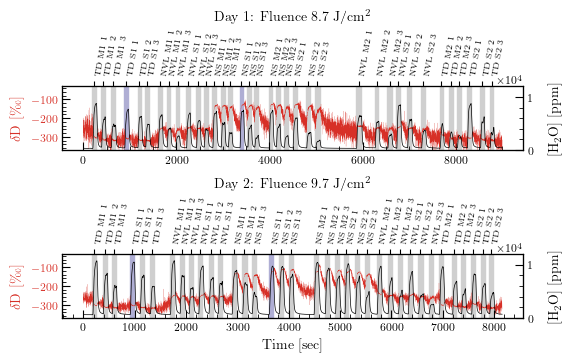

In [20]:


fig_width_cm = 15  # Reduce width to 90% of double column width
fig_height_cm = 23.3 * 0.4  # Reduce height to 90% of maximum height

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches



def plot_combined_data(dfs, intervals, filename):
    def set_common_ticks(ax, right=False):
        ax.tick_params(axis='both', which='major', direction='in', length=6, right=right, top=False, bottom=True)
        ax.tick_params(axis='both', which='minor', direction='in', length=3, right=right, top=False, bottom=True)
        ax.minorticks_on()


    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(fig_width_in, fig_height_in))
    # Define titles and fluence levels
    titles = [u'Day 1: Fluence 8.7 J/cm$^{2}$', u'Day 2: Fluence 9.7 J/cm$^{2}$']
    for i, (df, interval) in enumerate(zip(dfs, intervals)):
        ax = axs[i]
        ax.plot(df['Seconds'], df['Delta_D_H'], color='#d73027', linewidth=0.1)
        ax.tick_params(axis='y', labelcolor='#d73027')
        ax.set_ylabel(u'$\delta$D [‰]', color='#d73027', labelpad=5)#'#e31a1c'
        ax.set_title(titles[i])

        # Highlight intervals and annotate them
        for start, end, id, role in interval:
            color = '#afaed4' if id in ['TD S1 1', 'NS S1 1'] else '#cfcfcf'  # Specific color for certain IDs
            ax.axvspan(start, end, color=color, alpha=1)

        # Water plot on twin axis
        ax3 = ax.twinx()
        ax3.plot(df['Seconds'], df['H2O'], color='black', linewidth=0.5)
        ax3.tick_params(axis='y', labelcolor='black')
        ax3.set_ylabel(u'[H$_2$O] [ppm]', color='black', labelpad=10)
        ax3.set_ylim(0,12000)
        ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        set_common_ticks(ax)
        set_common_ticks(ax3, right=True)

        if i == len(dfs) - 1:  # Only set x-label for the last subplot
            ax.set_xlabel('Time [sec]')

        # Adjust secondary x-axis for role-based labels
        ax2 = ax.twiny()
        ax2.set_ylim(-370,-30)
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks([(start + end) / 2 for start, end, _, _ in interval])
        ax2.set_xticklabels([id for _, _, id, _ in interval], rotation=80, ha='left', fontsize=6)

    fig.tight_layout()
    plt.show()

    # Save the figure
    fig.savefig(filename, format='eps',dpi=600, bbox_inches='tight')
    fig.savefig(filename, format='tiff', dpi=600, bbox_inches='tight')

# Plot
plot_combined_data([df8_processed_p, df9_processed_p], [df8_seconds_p, df9_seconds_p], 'combined_days_data.eps')

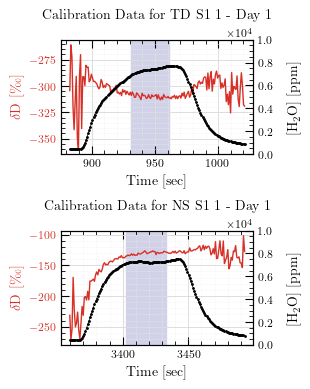

In [21]:
fig_width_cm = 8
fig_height_cm = 10

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches


def create_calibration_dfs(df, intervals_seconds_with_ids):
    # Initialize separate DataFrames for each calibration ID
    dfs = {}

    # Filter and populate the DataFrames
    for start, end, id, role in intervals_seconds_with_ids:
        if role == 'Calibration':
            # Extend the end time by 30 seconds
            extended_end = end + 60
            calibration_df = df[(df['Seconds'] >= start) & (df['Seconds'] <= extended_end)].copy()
            calibration_df['ID'] = id
            dfs[id] = calibration_df

    return dfs

df8_calibrations = create_calibration_dfs(df8_processed_p, df8_seconds_p)
df9_calibrations = create_calibration_dfs(df9_processed_p, df9_seconds_p)



def set_common_ticks(ax, right=False, no_grid=False):
    ax.tick_params(axis='both', which='major', direction='in', length=6, right=right, top=True, bottom=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=3, right=right, top=True, bottom=True)
    ax.minorticks_on()
    if not no_grid:
        ax.grid(which='major', color='#DDDDDD', linewidth=0.7)
        ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)


def plot_on_axes(df, ax, title):
    if df.empty:
        print("No data to plot for:", title)
        return

    # Plot Delta_D_H on the given ax
    ax.plot(df['Seconds'], df['Delta_D_H'], color='#d73027', linewidth=1)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel(u'$\delta$D [‰]', color='#d73027')
    ax.tick_params(axis='y', labelcolor='#d73027')

    # Highlight the last 30 seconds in a different color
    ax.axvspan(df['Seconds'].max() - 90, df['Seconds'].max()-60, color='#d1d2e7', alpha=1)

    # Water plot on twin axis
    ax2 = ax.twinx()
    ax2.plot(df['Seconds'], df['H2O'], color='black', linewidth=0.5, marker='o', linestyle='-', markersize=1)
    ax2.set_ylabel(u'[H$_2$O] [ppm]', color='black', labelpad=10)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0, 10000)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    # Set common tick settings
    set_common_ticks(ax)
    set_common_ticks(ax2, right=True, no_grid=True)  # Disable grid on twin axes


    # Set subplot title
    ax.set_title(title)

def plot_calibration_data(dfs_with_titles):
    rows = 2  # Number of rows
    cols = len(dfs_with_titles) // rows + (len(dfs_with_titles) % rows > 0)  # Calculate columns required per row
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width_in, fig_height_in))
    axes = axes.flatten()  # Flatten if multiple axes

    for ax, (df, title) in zip(axes, dfs_with_titles):
        plot_on_axes(df, ax, title)

    # Hide unused subplots if any
    for ax in axes[len(dfs_with_titles):]:
        ax.set_visible(False)

    fig.tight_layout()
    plt.show()
    fig.savefig('calibration_data.eps', format='eps', dpi=600,bbox_inches='tight')
    fig.savefig('calibration_data.tiff', format='tiff',dpi=600, bbox_inches='tight')




plot_calibration_data([
    (df8_calibrations.get('TD S1 1', pd.DataFrame()), 'Calibration Data for TD S1 1 - Day 1'),
    # (df9_calibrations.get('TD S1 1', pd.DataFrame()), 'Calibration Data for TD S1 1 - Day 2'),
    (df8_calibrations.get('NS S1 1', pd.DataFrame()), 'Calibration Data for NS S1 1 - Day 1'),
    # (df9_calibrations.get('NS S1 1', pd.DataFrame()), 'Calibration Data for NS S1 1 - Day 2')
])

#CALIBRATION#

In [22]:
import pandas as pd

class PrepareDataUsedForCalibration:
    def __init__(self, df, intervals_seconds_with_ids):
        self.df = df
        self.intervals_seconds_with_ids = intervals_seconds_with_ids

    def create_calibration_dfs(self):
        # Initialize separate DataFrames for each calibration ID
        dfs = {}
        for start, end, id, role in self.intervals_seconds_with_ids:
            if role == 'Calibration':
                calibration_df = self.df[(self.df['Seconds'] >= start) & (self.df['Seconds'] <= end)].copy()
                calibration_df['ID'] = id
                dfs[id] = calibration_df
        return dfs

    def extract_last_30_seconds(self, df):
        if df.empty:
            return None  # Return None if the DataFrame is empty
        end_seconds = df['Seconds'].max()
        start_seconds = max(df['Seconds'].min(), end_seconds - 30)
        return df[(df['Seconds'] >= start_seconds) & (df['Seconds'] <= end_seconds)]

    def calculate_stats(self, df):
        if df is None:
            return pd.DataFrame()  # Return empty DataFrame if input df is None
        means = df[['H2O', 'Delta_18_16', 'Delta_D_H']].mean()
        stds = df[['H2O', 'Delta_18_16', 'Delta_D_H']].std(ddof=1)
        stats_df = pd.DataFrame({
            'Mean H2O': [means['H2O']],
            'Std H2O': [stds['H2O']],
            'Mean Delta_18_16': [means['Delta_18_16']],
            'Std Delta_18_16': [stds['Delta_18_16']],
            'Mean Delta_D_H': [means['Delta_D_H']],
            'Std Delta_D_H': [stds['Delta_D_H']]
        })
        return stats_df

    def process_and_calculate_stats(self):
        calibrations = self.create_calibration_dfs()
        last_30_seconds_data = {key: self.extract_last_30_seconds(df) for key, df in calibrations.items()}
        stats_data = {key: self.calculate_stats(df) for key, df in last_30_seconds_data.items()}
        final_stats_df = pd.concat(stats_data.values(), keys=stats_data.keys(), names=['Calibration ID', 'Index']).reset_index(level='Index', drop=True)
        return final_stats_df


# Calibration Data
calibration_processor_df8 = PrepareDataUsedForCalibration(df8_processed, df8_seconds)
final_stats_df8 = calibration_processor_df8.process_and_calculate_stats()

calibration_processor_df9 = PrepareDataUsedForCalibration(df9_processed, df9_seconds)
final_stats_df9 = calibration_processor_df9.process_and_calculate_stats()

# Display the results
print("Final Statistics for df8:")
print(final_stats_df8)
print("\nFinal Statistics for df9:")
print(final_stats_df9)


Final Statistics for df8:
                   Mean H2O     Std H2O  Mean Delta_18_16  Std Delta_18_16  \
Calibration ID                                                               
TD S1 1         7374.373484  212.905474        -39.334970         0.302412   
NS S1 1         7247.340516   35.304759        -15.755564         0.361172   

                Mean Delta_D_H  Std Delta_D_H  
Calibration ID                                 
TD S1 1            -309.891088       1.838190  
NS S1 1            -130.330010       2.349146  

Final Statistics for df9:
                    Mean H2O     Std H2O  Mean Delta_18_16  Std Delta_18_16  \
Calibration ID                                                                
TD S1 1         10087.820525  374.235847        -38.322074         0.357730   
NS S1 1          9437.097530  333.189008        -14.271103         0.301077   

                Mean Delta_D_H  Std Delta_D_H  
Calibration ID                                 
TD S1 1            -303.95456

In [23]:

def calculate_coefficients(stats_df, true_values):
    coefficients = {}
    for isotope, iso_key in zip(['Delta_18_16', 'Delta_D_H'], ['d18', 'dD']):
        # Calculating for TD
        x_TD = stats_df.loc['TD S1 1', f'Mean {isotope}']
        y_TD = true_values['TD'][iso_key]

        # Calculating for NS
        x_NS = stats_df.loc['NS S1 1', f'Mean {isotope}']
        y_NS = true_values['NS'][iso_key]

        # Coefficient calculation
        a, b = (y_NS - y_TD) / (x_NS - x_TD), y_TD - (y_NS - y_TD) / (x_NS - x_TD) * x_TD
        coefficients[isotope] = {'Slope': a, 'Intercept': b}

    return coefficients

def display_coefficients(coefficients):
    for isot, vals in coefficients.items():
        print(f"{isot} Calibration: Slope (a) = {vals['Slope']:.5f}, Intercept (b) = {vals['Intercept']:.5f}")



# True values for calibration
true_values = {
    'TD': {'d18': -38.82, 'dD': -307.00},
    'NS': {'d18': -15.36, 'dD': -112.62}
}

# Apply the coefficient calculation to df8 and df9
coefficients_df8 = calculate_coefficients(final_stats_df8, true_values)
coefficients_df9 = calculate_coefficients(final_stats_df9, true_values)

# Output results for both data sets
print("Coefficients for df8:")
display_coefficients(coefficients_df8)

print("\nCoefficients for df9:")
display_coefficients(coefficients_df9)



def apply_calibration(df, coefficients):
    if df.empty or not coefficients:
        return df

    # Make a copy to ensure changes do not affect the original unexpectedly
    df = df.copy()

    # Apply the calibration formula to the respective columns

    df['Delta_18_16_cal'] = df['Delta_18_16'] * coefficients['Delta_18_16']['Slope'] + coefficients['Delta_18_16']['Intercept']
    df['Delta_D_H_cal'] = df['Delta_D_H'] * coefficients['Delta_D_H']['Slope'] + coefficients['Delta_D_H']['Intercept']

    return df



# Calibrate df8_processed
df8_calibrated = apply_calibration(df8_processed, coefficients_df8)

# Calibrate df9_processed
df9_calibrated = apply_calibration(df9_processed, coefficients_df9)





Coefficients for df8:
Delta_18_16 Calibration: Slope (a) = 0.99494, Intercept (b) = 0.31578
Delta_D_H Calibration: Slope (a) = 1.08253, Intercept (b) = 28.46596

Coefficients for df9:
Delta_18_16 Calibration: Slope (a) = 0.97543, Intercept (b) = -1.43956
Delta_D_H Calibration: Slope (a) = 1.08893, Intercept (b) = 23.98572


# Data Analysis - Calibrated Data #

In [24]:
def analyze_intervals(df, intervals_seconds_with_ids, true_values):
    results_df = pd.DataFrame()
    # Process each interval
    for start, end, ID, _ in intervals_seconds_with_ids:
        last_30_start = max(start, end - 30)  # Last 30 seconds of the interval
        mask = (df['Seconds'] >= last_30_start) & (df['Seconds'] <= end)
        interval_data = df.loc[mask]

        # Calculate means and standard deviations
        mean_h2o = interval_data['H2O'].mean()
        std_h2o = interval_data['H2O'].std(ddof=1)
        mean_delta_18_16 = interval_data['Delta_18_16_cal'].mean()
        std_delta_18_16 = interval_data['Delta_18_16_cal'].std(ddof=1)
        mean_delta_d_h = interval_data['Delta_D_H_cal'].mean()
        std_delta_d_h = interval_data['Delta_D_H_cal'].std(ddof=1)

        # Determine sample type from ID and calculate accuracy for both isotopes
        sample_type = ID.split()[0]  # Extract 'TD', 'NS', 'NVL' from the ID
        true_d18 = true_values[sample_type]['d18']
        true_dD = true_values[sample_type]['dD']
        accuracy_d18 = true_d18 - mean_delta_18_16
        accuracy_dD = true_dD - mean_delta_d_h

        # Calculate z-scores
        z_score_d18 = (mean_delta_18_16 - true_d18) / std_delta_18_16 if std_delta_18_16 != 0 else None
        z_score_dD = (mean_delta_d_h - true_dD) / std_delta_d_h if std_delta_d_h != 0 else None

        # Append results to the DataFrame
        new_row = pd.DataFrame({
            'ID': [ID],
            'Mean H2O': [mean_h2o],
            'Std H2O': [std_h2o],
            'Mean Delta_18_16': [mean_delta_18_16],
            'Std Delta_18_16': [std_delta_18_16],
            'Mean Delta_D_H': [mean_delta_d_h],
            'Std Delta_D_H': [std_delta_d_h],
            'Accuracy Delta_18_16': [accuracy_d18],
            'Z-Score Delta_18_16': [z_score_d18],
            'Accuracy Delta_D_H': [accuracy_dD],
            'Z-Score Delta_D_H': [z_score_dD]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df

# True values for calibration
true_values = {
    'TD': {'d18': -38.82, 'dD': -307.00},
    'NS': {'d18': -15.36, 'dD': -112.62},
    'NVL': {'d18': -31.15, 'dD': -240.02},
    'TEDRIST': {'d18': -21.34, 'dD': -165.4}
}


# Standards
results_df8_r = analyze_intervals(df8_calibrated, df8_seconds, true_values)
results_df9_r = analyze_intervals(df9_calibrated, df9_seconds, true_values)

#Ice Core
results_df8_i = analyze_intervals(df8_calibrated, df8_ice_seconds, true_values)
results_df9_i = analyze_intervals(df9_calibrated, df9_ice_seconds, true_values)

# Ice Standards - Results

In [25]:
def format_and_create_latex(df):
    # Ensure correct data types and rounding
    df['Mean H2O'] = df['Mean H2O'].astype(int)
    df['Mean Delta_18_16'] = df['Mean Delta_18_16'].round(2)
    df['Std Delta_18_16'] = df['Std Delta_18_16'].round(2)
    df['Mean Delta_D_H'] = df['Mean Delta_D_H'].round(2)
    df['Std Delta_D_H'] = df['Std Delta_D_H'].round(2)
    df['Accuracy Delta_18_16'] = df['Accuracy Delta_18_16'].round(2)
    df['Z-Score Delta_18_16'] = df['Z-Score Delta_18_16'].round(2)
    df['Accuracy Delta_D_H'] = df['Accuracy Delta_D_H'].round(2)
    df['Z-Score Delta_D_H'] = df['Z-Score Delta_D_H'].round(2)

    # Define the LaTeX formatting
    latex_str = r'''
\begin{table*}[h]
\small
  \caption{Results for ice standards measured at fluence 8.7 $J/cm^{2}$.}
  \label{tab:results8}
  \begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lrrrrrrrrr}
    \hline
    ID & [H$_{2}$O]/ppm & $\delta^{18}\mathrm{O}$(\textperthousand) & Std & $\delta\mathrm{D}$(\textperthousand) & Std & $\Delta\delta^{18}\mathrm{O}$(\textperthousand) & Z-score & $\Delta\delta\mathrm{D}$(\textperthousand) & Z-score \\
    \hline
    '''
    # Add data rows
    for index, row in df.iterrows():
        latex_str += f"{row['ID']} & {row['Mean H2O']} & {row['Mean Delta_18_16']} & {row['Std Delta_18_16']} & {row['Mean Delta_D_H']} & {row['Std Delta_D_H']} & {row['Accuracy Delta_18_16']} & {row['Z-Score Delta_18_16']} & {row['Accuracy Delta_D_H']} & {row['Z-Score Delta_D_H']} \\\\\n"

    # Close the table
    latex_str += r'''
    \hline
  \end{tabular*}
\end{table*}
    '''
    return latex_str


# Format and create LaTeX table
latex_output = format_and_create_latex(results_df8_r)
print(latex_output)




\begin{table*}[h]
\small
  \caption{Results for ice standards measured at fluence 8.7 $J/cm^{2}$.}
  \label{tab:results8}
  \begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lrrrrrrrrr}
    \hline
    ID & [H$_{2}$O]/ppm & $\delta^{18}\mathrm{O}$(\textperthousand) & Std & $\delta\mathrm{D}$(\textperthousand) & Std & $\Delta\delta^{18}\mathrm{O}$(\textperthousand) & Z-score & $\Delta\delta\mathrm{D}$(\textperthousand) & Z-score \\
    \hline
    TD M1 1 & 8480 & -38.26 & 0.36 & -300.9 & 1.77 & -0.56 & 1.55 & -6.1 & 3.46 \\
TD M1 2 & 5822 & -38.92 & 0.46 & -314.05 & 2.31 & 0.1 & -0.21 & 7.05 & -3.06 \\
TD M1 3 & 4605 & -38.91 & 0.61 & -315.66 & 2.5 & 0.09 & -0.15 & 8.66 & -3.46 \\
TD S1 1 & 7374 & -38.82 & 0.3 & -307.0 & 1.99 & -0.0 & 0.0 & 0.0 & 0.0 \\
TD S1 2 & 6242 & -39.11 & 0.39 & -315.72 & 1.88 & 0.29 & -0.74 & 8.72 & -4.64 \\
TD S1 3 & 4816 & -39.08 & 0.5 & -317.79 & 2.15 & 0.26 & -0.51 & 10.79 & -5.02 \\
NVL M1 1 & 6403 & -31.19 & 0.37 & -248.39 & 2.48 & 0.04 & -0.11 & 8.37 & -

In [26]:
# List of IDs to be removed
ids_to_remove8 = ["TD M2 1", "TD S1 1", "NS S1 1"]
ids_to_remove9 = [ "TD S1 1", "NS S1 1"]
# Filter the DataFrame to exclude the rows with the specified IDs
results_df8 = results_df8_r.copy()[~results_df8_r.copy()['ID'].isin(ids_to_remove8)]
results_df9 = results_df9_r.copy()[~results_df9_r.copy()['ID'].isin(ids_to_remove9)]



In [27]:
def add_and_round_group_overall_means(df, target_df):
    # Define the columns for which the means should be calculated
    columns_to_mean = ['Mean H2O',   'Std Delta_18_16',  'Std Delta_D_H', 'Accuracy Delta_18_16',  'Accuracy Delta_D_H']
    df['Group'] = df['ID'].str[-1]
    # Calculate group means (assuming groups are already defined somehow, e.g., by experimental setup)
    group_means = df.groupby('Group').agg({col: 'mean' for col in columns_to_mean}).reset_index()
    group_means['ID'] = group_means['Group'].apply(lambda x: f"Layer {x}")  # Creating a friendly name
    group_means.drop(columns='Group', inplace=True)

    # Calculate overall mean
    overall_means = df[columns_to_mean].mean().to_frame().T
    overall_means.insert(0, 'ID', 'All')

    # Append calculated group and overall means to the target DataFrame
    updated_df = pd.concat([target_df, group_means, overall_means], ignore_index=True)

    # Round the specific columns
    for col in columns_to_mean:
        updated_df[col] = updated_df[col].round(2)

    return updated_df

df_with_means = add_and_round_group_overall_means(results_df8, results_df8_r)
df_with_means


,ID,Mean H2O,Std H2O,Mean Delta_18_16,Std Delta_18_16,Mean Delta_D_H,Std Delta_D_H,Accuracy Delta_18_16,Z-Score Delta_18_16,Accuracy Delta_D_H,Z-Score Delta_D_H
0,TD M1 1,8480.00,224.796747,-38.26,0.36,-300.90,1.77,-0.56,1.55,-6.10,3.46
1,TD M1 2,5822.00,142.127485,-38.92,0.46,-314.05,2.31,0.10,-0.21,7.05,-3.06
2,TD M1 3,4605.00,146.229002,-38.91,0.61,-315.66,2.50,0.09,-0.15,8.66,-3.46
3,TD S1 1,7374.00,212.905474,-38.82,0.30,-307.00,1.99,-0.00,0.00,0.00,0.00
4,TD S1 2,6242.00,57.657594,-39.11,0.39,-315.72,1.88,0.29,-0.74,8.72,-4.64
5,TD S1 3,4816.00,42.451153,-39.08,0.50,-317.79,2.15,0.26,-0.51,10.79,-5.02
6,NVL M1 1,6403.00,67.192547,-31.19,0.37,-248.39,2.48,0.04,-0.11,8.37,-3.37
7,NVL M1 2,4045.00,51.541051,-31.51,0.58,-250.86,2.94,0.36,-0.63,10.84,-3.69
8,NVL M1 3,2624.00,50.577607,-31.34,0.78,-254.24,4.39,0.19,-0.24,14.22,-3.24
9,NVL S1 1,6737.00,146.673007,-31.24,0.31,-243.55,1.75,0.09,-0.28,3.53,-2.02


In [28]:
def format_value(val, is_int=False):
    """Format values for LaTeX output."""
    # Check if the value is NaN, and return an empty string if so
    if pd.isna(val):
        return ''
    # If the value should be an integer (used for the Mean H2O column)
    if is_int:
        return f"{int(round(val))}"  # Convert float to int and format as string
    # Otherwise, format as float with two decimal places
    return f"{val:.2f}"

def format_and_create_latex(df):
    # Define the LaTeX formatting
    latex_str = r'''
\begin{table*}[h]
\small
  \caption{Results for ice standards measured at fluence 9.7 $J/cm^{2}$.}
  \label{tab:results9}
  \begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lrrrrrrrrr}
    \hline
    ID & [H$_{2}$O]/ppm & $\delta^{18}\mathrm{O}$(\textperthousand) & Std & $\delta\mathrm{D}$(\textperthousand) & Std & $\Delta\delta^{18}\mathrm{O}$(\textperthousand) & Z-score & $\Delta\delta\mathrm{D}$(\textperthousand) & Z-score \\
    \hline
    '''
    # Add data rows with conditional \hline
    for index, row in df.iterrows():
        if row['ID'] == 'Layer 1':
            latex_str += r'\hline' + '\n'  # Add an \hline before Layer 1
        latex_str += f"{row['ID']} & {format_value(row['Mean H2O'], is_int=True)} & {format_value(row['Mean Delta_18_16'])} & {format_value(row['Std Delta_18_16'])} & {format_value(row['Mean Delta_D_H'])} & {format_value(row['Std Delta_D_H'])} & {format_value(row['Accuracy Delta_18_16'])} & {format_value(row['Z-Score Delta_18_16'])} & {format_value(row['Accuracy Delta_D_H'])} & {format_value(row['Z-Score Delta_D_H'])} \\\\\n"
        if row['ID'] == 'Layer 3':
            latex_str += r'\hline' + '\n'  # Add an \hline after Layer 3

    # Close the table
    latex_str += r'''
    \hline
  \end{tabular*}
\end{table*}
    '''
    return latex_str


latex_output = format_and_create_latex(df_with_means)
print(latex_output)



\begin{table*}[h]
\small
  \caption{Results for ice standards measured at fluence 9.7 $J/cm^{2}$.}
  \label{tab:results9}
  \begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lrrrrrrrrr}
    \hline
    ID & [H$_{2}$O]/ppm & $\delta^{18}\mathrm{O}$(\textperthousand) & Std & $\delta\mathrm{D}$(\textperthousand) & Std & $\Delta\delta^{18}\mathrm{O}$(\textperthousand) & Z-score & $\Delta\delta\mathrm{D}$(\textperthousand) & Z-score \\
    \hline
    TD M1 1 & 8480 & -38.26 & 0.36 & -300.90 & 1.77 & -0.56 & 1.55 & -6.10 & 3.46 \\
TD M1 2 & 5822 & -38.92 & 0.46 & -314.05 & 2.31 & 0.10 & -0.21 & 7.05 & -3.06 \\
TD M1 3 & 4605 & -38.91 & 0.61 & -315.66 & 2.50 & 0.09 & -0.15 & 8.66 & -3.46 \\
TD S1 1 & 7374 & -38.82 & 0.30 & -307.00 & 1.99 & -0.00 & 0.00 & 0.00 & 0.00 \\
TD S1 2 & 6242 & -39.11 & 0.39 & -315.72 & 1.88 & 0.29 & -0.74 & 8.72 & -4.64 \\
TD S1 3 & 4816 & -39.08 & 0.50 & -317.79 & 2.15 & 0.26 & -0.51 & 10.79 & -5.02 \\
NVL M1 1 & 6403 & -31.19 & 0.37 & -248.39 & 2.48 & 0.04 & -0.11

# Ice core - Results

In [29]:
def add_and_round_overall_means(df):
    # Define the columns for which the means should be calculated
    columns_to_mean = ['Mean H2O',  'Std Delta_18_16',  'Std Delta_D_H', 'Accuracy Delta_18_16',  'Accuracy Delta_D_H']

    # Calculate overall mean
    overall_means = df[columns_to_mean].mean().to_frame().T
    overall_means.insert(0, 'ID', 'All')  # Add an identifier for the overall means row

    # Append calculated overall means to the DataFrame
    df = pd.concat([df, overall_means], ignore_index=True)

    # Round the specific columns
    for col in columns_to_mean:
        df[col] = df[col].round(2)  # Ensure rounding is applied to all data, including newly added means

    return df

# Assuming you have a DataFrame 'results_df9' already loaded
df_with_means = add_and_round_overall_means(results_df8_i)
df_with_means


latex_output = format_and_create_latex(df_with_means)
print(latex_output)



\begin{table*}[h]
\small
  \caption{Results for ice standards measured at fluence 9.7 $J/cm^{2}$.}
  \label{tab:results9}
  \begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lrrrrrrrrr}
    \hline
    ID & [H$_{2}$O]/ppm & $\delta^{18}\mathrm{O}$(\textperthousand) & Std & $\delta\mathrm{D}$(\textperthousand) & Std & $\Delta\delta^{18}\mathrm{O}$(\textperthousand) & Z-score & $\Delta\delta\mathrm{D}$(\textperthousand) & Z-score \\
    \hline
    TEDRIST 1 & 5599 & -20.00 & 0.37 & -162.92 & 2.55 & -1.34 & 3.62 & -2.48 & 0.97 \\
TEDRIST 2 & 4980 & -20.10 & 0.41 & -162.96 & 2.24 & -1.24 & 3.00 & -2.44 & 1.09 \\
TEDRIST 3 & 4783 & -20.39 & 0.49 & -162.90 & 2.57 & -0.95 & 1.94 & -2.50 & 0.97 \\
TEDRIST 4 & 4387 & -19.99 & 0.40 & -160.02 & 2.42 & -1.35 & 3.36 & -5.38 & 2.22 \\
TEDRIST 5 & 6033 & -19.59 & 0.50 & -157.87 & 2.12 & -1.75 & 3.50 & -7.53 & 3.55 \\
TEDRIST 6 & 5943 & -19.97 & 0.38 & -161.20 & 2.09 & -1.37 & 3.60 & -4.20 & 2.02 \\
TEDRIST 7 & 6078 & -19.58 & 0.33 & -157.80 & 1.99 &

# Data Analysis - Vizualization #

In [30]:

# results_df8_r and results_df9_r : results for ice standards
results_df1 = results_df8_r.copy()
results_df2 = results_df9_r.copy()

# Add 'fluence' column to differentiate the data
results_df1['Fluence'] = 8.7
results_df2['Fluence'] = 9.7

# Combine both DataFrames
combined_df = pd.concat([results_df1, results_df2])


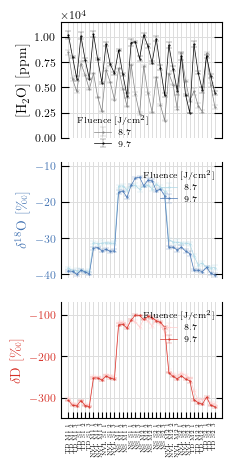

In [31]:
fig_width_cm = 6  # Prescribed maximum width in cm
fig_height_cm = 12  # An arbitrary height to accommodate both plots vertically

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches

# Create the figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(fig_width_in, fig_height_in))
# Metrics to plot
metrics = ['Mean H2O', 'Mean Delta_18_16', 'Mean Delta_D_H']
std_metrics = ['Std H2O', 'Std Delta_18_16', 'Std Delta_D_H']

df = combined_df.copy()

colors = ['grey', 'black']  # Colors for the different fluences

# Plot H2O Content with Error Bars
for fluence, color in zip([8.7, 9.7], colors):
    subset = df[df['Fluence'] == fluence]
    axes[0].errorbar(subset['ID'], subset['Mean H2O'], yerr=subset['Std H2O'], fmt='o-', color=color, capsize=2,capthick=0.2, markersize=0.5, elinewidth=0.2,linewidth=0.5,label=f'{fluence}') #label=f'Fluence: {fluence} J/cm$^2$'
axes[0].set_ylim(0,11500)
axes[0].tick_params(axis='y', labelcolor='black')
axes[0].legend(title='Fluence [J/cm$^2$]', frameon=False)
axes[0].set_ylabel('[H$_2$O] [ppm]')
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].tick_params(axis='both', which='major', direction='in', length=6, left=True,right=True, top=False, bottom=False)
axes[0].tick_params(axis='y', which='minor', direction='in', length=3, left=True,right=True, top=False, bottom=False)
axes[0].grid(which='major', color='#DDDDDD', linewidth=0.7)
axes[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
for spine in ['bottom']:
  axes[0].spines[spine].set_visible(False)
axes[0].set_xticklabels([])

# Plot Delta_18_16 with Error Bars
for fluence, color in zip([8.7, 9.7], ['#add8e6', '#4575b4']):
    subset = df[df['Fluence'] == fluence]
    axes[1].errorbar(subset['ID'], subset['Mean Delta_18_16'], yerr=subset['Std Delta_18_16'], fmt='o-', color=color, capsize=2,capthick=0.2,elinewidth=0.2, markersize=0.5, linewidth=0.5,label=f'{fluence}')
axes[1].tick_params(axis='y', labelcolor='#4575b4')

axes[1].set_ylabel(u'$\delta^{18}$O [‰]', color='#4575b4')
axes[1].legend(title='Fluence [J/cm$^2$]', frameon=False)
axes[1].tick_params(axis='both', which='major', direction='in', length=6, left=True,right=True, top=False, bottom=False)
axes[1].tick_params(axis='y', which='minor', direction='in', length=3, left=True,right=True, top=False, bottom=False)
axes[1].grid(which='major', color='#DDDDDD', linewidth=0.7)
axes[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
for spine in ['bottom', 'top']:
  axes[1].spines[spine].set_visible(False)
axes[1].set_xticklabels([])



# Plot Delta_D_H with Error Bars
for fluence, color in zip([8.7, 9.7], ['#ffcccc', '#d73027']):
    subset = df[df['Fluence'] == fluence]
    axes[2].errorbar(subset['ID'], subset['Mean Delta_D_H'], yerr=subset['Std Delta_D_H'], fmt='o-', color=color,capsize=2,capthick=0.2, markersize=0.5, elinewidth=0.2,linewidth=0.5, label=f'{fluence}')
axes[2].tick_params(axis='y', labelcolor='#d73027')
axes[2].set_ylabel(u'$\delta$D [‰]', color='#d73027')
axes[2].tick_params(axis='x', rotation=90)
axes[2].tick_params(axis='both', which='major', direction='in', length=4, left=True,right=True, top=False, bottom=True)
axes[2].tick_params(axis='y', which='minor', direction='in', length=3, left=True,right=True, top=False, bottom=True)
axes[2].grid(which='major', color='#DDDDDD', linewidth=0.7)
axes[2].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
for spine in [ 'top']:
  axes[2].spines[spine].set_visible(False)
l0=axes[0].legend(title='Fluence [J/cm$^2$]', frameon=False, loc='lower left', bbox_to_anchor=(0.05, -0.15))
plt.setp(l0.get_title(), fontsize=6)  # Set a specific smaller font size
l1=axes[1].legend(title='Fluence [J/cm$^2$]', frameon=False, loc='upper right')
plt.setp(l1.get_title(), fontsize=6)  # Set a specific smaller font size
l2=axes[2].legend(title='Fluence [J/cm$^2$]', frameon=False, loc='upper right')
plt.setp(l2.get_title(), fontsize=6)  # Set a specific smaller font size
axes[1].set_ylim(-41, -9)
axes[2].set_ylim(-350, -70)
axes[-1].tick_params(axis='x', labelsize=4)



fig.savefig('plot_standards.eps', format='eps', dpi=600, bbox_inches='tight')
fig.savefig('plot_standards.tiff', format='tiff', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

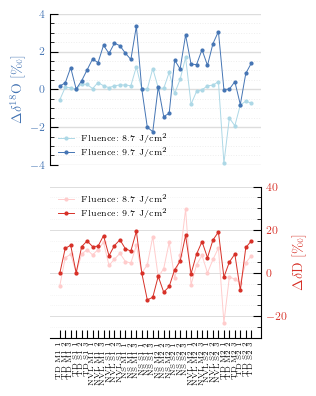

In [32]:
fig_width_cm = 3.2
fig_height_cm = 8/2

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches
fig, axs = plt.subplots(2, 1, figsize=(fig_width_cm, fig_height_cm), sharex=True)

# Iterate over each fluence group and plot
fluences = combined_df['Fluence'].unique()
colors = ['blue', 'red']  # Different colors for each fluence
marker_styles = ['o', 'o']  # Different markers for each fluence
colors = {8.7: ('#add8e6', '#ffcccc'), 9.7: ('#4575b4', '#d73027')}  # Pale blue for 8.7, blue for 9.7; Pale red for 8.7, red for 9.7

for i, fluence in enumerate(fluences):
    df_fluence = combined_df[combined_df['Fluence'] == fluence]
    color_18o, color_dh = colors[fluence]


    # Accuracy Delta 18O
    axs[0].plot(df_fluence['ID'], df_fluence['Accuracy Delta_18_16'], color=color_18o, marker='o', markersize=2, linestyle='-',linewidth=0.7, label=f'Fluence: {fluence} J/cm$^2$')
    axs[0].set_ylabel(u'$\Delta\delta^{18}$O [‰]', color='#4575b4')
    axs[0].tick_params(axis='y', labelcolor='#4575b4')
    axs[0].tick_params(axis='both', which='major', direction='in', length=6, right=False, top=False, bottom=False)
    axs[0].tick_params(axis='both', which='minor', direction='in', length=3, right=False, top=False, bottom=False)
    axs[0].minorticks_on()
    axs[0].grid(which='major', color='#DDDDDD', linewidth=1)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.7)

    for spine in ['top', 'right', 'bottom']:
        axs[0].spines[spine].set_visible(False)
    axs[0].set_ylim(-4,4)

    # Accuracy Delta D
    axs[1].plot(df_fluence['ID'], df_fluence['Accuracy Delta_D_H'], color=color_dh, marker='o',markersize=2, linestyle='-', linewidth=0.7, label=f'Fluence: {fluence} J/cm$^2$')
    axs[1].set_ylabel(u'$\Delta\delta$D [‰]', color='#d73027')
    axs[1].tick_params(axis='y', labelcolor='#d73027')
    axs[1].tick_params(axis='both', which='major', direction='in', length=6, right=False, top=False, bottom=True)
    axs[1].tick_params(axis='both', which='minor', direction='in', length=3, right=False, top=False, bottom=False)
    axs[1].minorticks_on()
    axs[1].grid(which='major', color='#DDDDDD', linewidth=0.7)
    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    axs[1].grid(which='both', axis='x', linestyle='')
    for spine in ['top', 'left']:
        axs[1].spines[spine].set_visible(False)
    axs[1].set_ylim(-30, 40)

axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()


# Remove x-axis from the first plot
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_xticklabels([])  # Remove x-axis tick labels
axs[0].xaxis.set_visible(False)  # Hide the x-axis completely


# Setting x-axis labels for the bottom graph only
axs[1].set_xticks(range(len(combined_df['ID'].unique())))
axs[1].set_xticklabels(combined_df['ID'].unique(), rotation=90, fontsize=5)


for ax in axs[:2]:
    ax.legend(loc='best', frameon=False)


fig.tight_layout()
plt.show()
fig.savefig('accuracy.eps', format='eps', dpi=600, bbox_inches='tight')
fig.savefig('accuracy.tiff', format='tiff', dpi=600,bbox_inches='tight')

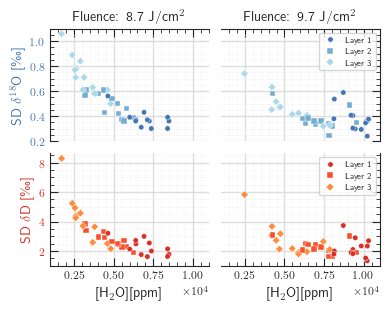

In [33]:
# Reds for Std Delta_D_H
layer_colors_reds = {
    'Layer 1': '#d73027',  # Dark Red
    'Layer 2': '#fc4e2a',  # Medium Red
    'Layer 3': '#fd8d3c',  # Light Red
}

# Blues for Std Delta_18_16
layer_colors_blues = {
    'Layer 1': '#4575b4',  # Dark Blue
    'Layer 2': '#74add1',  # Medium Blue
    'Layer 3': '#abd9e9',  # Light Blue
}



sns.set_style("ticks")
fig_width_cm = 10
fig_height_cm = 8

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches

df=combined_df.copy()

# Create a new column 'Layer' by extracting the last character from the 'ID'
df['Layer'] = df['ID'].apply(lambda x: 'Layer ' + x.split()[-1])

sns.set_style("ticks")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(fig_width_in, fig_height_in ), sharex='col', sharey='row')
fig.subplots_adjust(hspace=1, wspace=1)

# Plot 1: Fluence 8.7 with Std Delta_18_16
sns.scatterplot(data=df[df['Fluence'] == 8.7], x='Mean H2O', y='Std Delta_18_16', hue='Layer', palette=layer_colors_blues, style='Layer', markers=['o', 's', 'D'], s=15, ax=axes[0, 0])
axes[0, 0].set_title(u'Fluence: 8.7 J/cm$^{2}$')
axes[0,0].set_ylabel(u'SD $\delta^{18}$O [‰]', color='#4575b4')
axes[0,0].tick_params(axis='y', labelcolor='#4575b4')
axes[0,0].tick_params(axis='both', which='major', direction='in', length=6, right=False, top=True, bottom=False)
axes[0,0].tick_params(axis='both', which='minor', direction='in', length=3, right=False, top=True, bottom=False)
axes[0,0].minorticks_on()
axes[0,0].grid(which='major', color='#DDDDDD', linewidth=1)
axes[0,0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.7)
for spine in [ 'right', 'bottom']:
  axes[0,0].spines[spine].set_visible(False)
axes[0, 0].legend().remove()


axes[0, 0].legend().remove()  # Optional: Remove legend from this plot
axes[0, 0].set_xlim(1000, 11000)

# Plot 2: Fluence 8.7 with Std Delta_D_H
sns.scatterplot(data=df[df['Fluence'] == 8.7], x='Mean H2O', y='Std Delta_D_H', hue='Layer', palette=layer_colors_reds, style='Layer', markers=['o', 's', 'D'], s=15, ax=axes[1, 0])
axes[1, 0].set_title('')
axes[1, 0].set_xlabel(u'[H$_{2}$O][ppm]')
axes[1,0].set_ylabel(u'SD $\delta$D [‰]', color='#d73027')
axes[1,0].tick_params(axis='y', labelcolor='#d73027')
axes[1,0].tick_params(axis='both', which='major', direction='in', length=6, right=False, top=False, bottom=True)
axes[1,0].tick_params(axis='both', which='minor', direction='in', length=3, right=False, top=False, bottom=True)
axes[1,0].minorticks_on()
axes[1,0].grid(which='major', color='#DDDDDD', linewidth=1)
axes[1,0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.7)
for spine in ['top', 'right']:
  axes[1,0].spines[spine].set_visible(False)
axes[1, 0].set_xlim(1000, 11000)
axes[1,0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes[1, 0].legend().remove()

# Plot 3: Fluence 9.7 with Std Delta_18_16
sns.scatterplot(data=df[df['Fluence'] == 9.7], x='Mean H2O', y='Std Delta_18_16', hue='Layer', palette=layer_colors_blues, style='Layer', markers=['o', 's', 'D'], s=15, ax=axes[0, 1])
axes[0, 1].set_title(u'Fluence: 9.7 J/cm$^{2}$')
axes[0, 1].set_xlabel(u'[H$_{2}$O][ppm]')
axes[0,1].set_ylabel(u'SD $\delta^{18}$O [‰]', color='#4575b4')
axes[0,1].tick_params(axis='y', labelcolor='#4575b4')
axes[0,1].tick_params(axis='both', which='major', direction='in', length=6, left=False,right=True, top=True, bottom=False)
axes[0,1].tick_params(axis='both', which='minor', direction='in', length=3, left=False,right=True, top=True, bottom=False)
axes[0,1].minorticks_on()
axes[0,1].grid(which='major', color='#DDDDDD', linewidth=1)
axes[0,1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.7)
for spine in ['left', 'bottom']:
  axes[0,1].spines[spine].set_visible(False)
axes[0, 1].legend(title=None)

axes[0, 1].set_xlim(1000, 11000)

# Plot 4: Fluence 9.7 with Std Delta_D_H
sns.scatterplot(data=df[df['Fluence'] == 9.7], x='Mean H2O', y='Std Delta_D_H', hue='Layer', palette=layer_colors_reds, style='Layer', markers=['o', 's', 'D'], s=15, ax=axes[1, 1])
axes[1, 1].set_title('')
axes[1, 1].set_xlabel(u'[H$_{2}$O][ppm]')

axes[1,1].set_ylabel(u'SD $\delta$D [‰]', color='#d73027')
axes[1,1].tick_params(axis='y', labelcolor='#d73027')
axes[1,1].tick_params(axis='both', which='major', direction='in', length=6, left=False,right=True, top=False, bottom=True)
axes[1,1].tick_params(axis='both', which='minor', direction='in', length=3, left=False,right=True, top=False, bottom=True)
axes[1,1].minorticks_on()
axes[1,1].grid(which='major', color='#DDDDDD', linewidth=1)
axes[1,1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.7)
for spine in ['top', 'left']:
  axes[1,1].spines[spine].set_visible(False)
axes[1, 1].set_xlim(1000, 11000)
axes[1,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes[1, 1].legend(title=None)

plt.tight_layout()
plt.show()

fig.savefig('std_plot_standards.eps', format='eps',dpi=600, bbox_inches='tight')
fig.savefig('std_plot_standards.tiff', format='tiff',dpi=600, bbox_inches='tight')

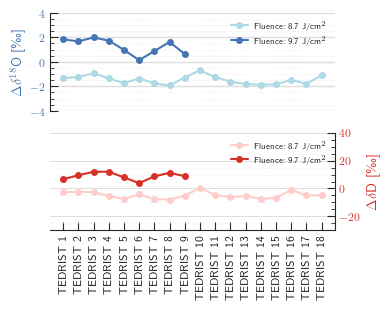

In [34]:

# Results for ice core section
results_df1 = results_df8_i.copy()
results_df2 = results_df9_i.copy()

# Add 'fluence' column to differentiate the data
results_df1['Fluence'] = 8.7
results_df2['Fluence'] = 9.7

# Combine both DataFrames
combined_df_i = pd.concat([results_df1, results_df2])


fig_width_cm = 10
fig_height_cm = 8

# Convert cm to inches
fig_width_in = fig_width_cm / 2.54  # Convert cm to inches
fig_height_in = fig_height_cm / 2.54  # Convert cm to inches

sns.set_style("ticks")
fig, axs = plt.subplots(2, 1, figsize=(fig_width_in, fig_height_in), sharex=True)

# Iterate over each fluence group and plot
fluences = combined_df_i['Fluence'].unique()
colors = ['blue', 'red']  # Different colors for each fluence
marker_styles = ['o', 'o']  # Different markers for each fluence
colors = {8.7: ('#add8e6', '#ffcccc'), 9.7: ('#4575b4', '#d73027')}  # Pale blue for 8.7, blue for 9.7; Pale red for 8.7, red for 9.7

for i, fluence in enumerate(fluences):
    df_fluence = combined_df_i[combined_df_i['Fluence'] == fluence]
    color_18o, color_dh = colors[fluence]

    # Accuracy Delta 18O
    axs[0].plot(df_fluence['ID'], df_fluence['Accuracy Delta_18_16'], color=color_18o, marker='o', linestyle='-', markersize=4, label=f'Fluence: {fluence} J/cm$^2$')
    axs[0].set_ylabel(u'$\Delta\delta^{18}$O [‰]', color='#4575b4')
    axs[0].tick_params(axis='y', labelcolor='#4575b4')
    axs[0].tick_params(axis='both', which='major', direction='in', length=6, right=False, top=False, bottom=False)
    axs[0].tick_params(axis='both', which='minor', direction='in', length=3, right=False, top=False, bottom=False)
    axs[0].minorticks_on()
    axs[0].grid(which='major', color='#DDDDDD', linewidth=1)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.7)

    for spine in ['top', 'right', 'bottom']:
        axs[0].spines[spine].set_visible(False)
    axs[0].set_ylim(-4,4)

    # Accuracy Delta D
    axs[1].plot(df_fluence['ID'], df_fluence['Accuracy Delta_D_H'], color=color_dh, marker='o', linestyle='-', markersize=4, label=f'Fluence: {fluence} J/cm$^2$')
    axs[1].set_ylabel(u'$\Delta\delta$D [‰]', color='#d73027')
    axs[1].tick_params(axis='y', labelcolor='#d73027')
    axs[1].tick_params(axis='both', which='major', direction='in', length=6, right=False, top=False, bottom=True)
    axs[1].tick_params(axis='both', which='minor', direction='in', length=3, right=False, top=False, bottom=False)
    axs[1].minorticks_on()
    axs[1].grid(which='major', color='#DDDDDD', linewidth=0.7)
    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    axs[1].grid(which='both', axis='x', linestyle='')
    for spine in ['top', 'left']:
        axs[1].spines[spine].set_visible(False)
    axs[1].set_ylim(-30, 40)

axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()


# Remove x-axis from the first plot
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_xticklabels([])  # Remove x-axis tick labels
axs[0].xaxis.set_visible(False)  # Hide the x-axis completely


# Setting x-axis labels for the bottom graph only
axs[1].set_xticks(range(len(combined_df_i['ID'].unique())))
axs[1].set_xticklabels(combined_df_i['ID'].unique(), rotation=90)


for ax in axs[:2]:
    ax.legend(loc='best', frameon=False)


fig.tight_layout()
plt.show()
fig.savefig('accuracy_ice.eps', format='eps', dpi=600,bbox_inches='tight')
fig.savefig('accuracy_ice.tiff', format='tiff', dpi=600,bbox_inches='tight')
